Text Classification with Keras

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize, regexp_tokenize

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
reviews = pd.read_csv('complaints_preprocessed.csv').dropna()

reviews.head() 

,Consumer complaint narrative,Issue,Issue_Code
0,name complaint made error neither made third p...,Incorrect information on your report,3.0
1,search point websit legitim believ websit wher...,Fraud or scam,2.0
2,particular account state owe list credit repor...,Incorrect information on your report,3.0
3,suppli proof doctrin estoppel silenc engelhard...,Attempts to collect debt not owed,0.0
4,hello write regard account credit report belon...,Incorrect information on your report,3.0


In [3]:
reviews['Issue'].value_counts(dropna=False) 

Incorrect information on your report    6652
Attempts to collect debt not owed       1923
Communication tactics                    441
Struggling to pay mortgage               428
Fraud or scam                            291
Name: Issue, dtype: int64

In [4]:
X = reviews[['Consumer complaint narrative']]
y = reviews['Issue']

le = LabelEncoder().fit(y)
y = le.transform(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = 321, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 321, stratify = y_train_val)

In [5]:
vect = TfidfVectorizer()

X_train_vec = vect.fit_transform(X_train['Consumer complaint narrative']).toarray()
X_val_vec = vect.transform(X_val['Consumer complaint narrative']).toarray()
X_test_vec = vect.transform(X_test['Consumer complaint narrative']).toarray() 

In [6]:
#Start with a sequential model
model = tf.keras.Sequential()

# Then add dense layer with relu activation
model.add(tf.keras.layers.Dense(units = 256,
                                input_shape = (vect.get_feature_names_out().shape[0],),
                                activation = 'relu'))
# And end with an output layer with sigmoid activation 
model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

# Finally, compile the model
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 

In [7]:
history = model.fit(X_train_vec, y_train,
                    validation_data = (X_val_vec, y_val),
                    epochs=100, callbacks=[callback])

Epoch 1/100
172/172 [==============================] - 7s 6ms/step - loss: 0.7554 - accuracy: 0.7443 - val_loss: 0.4540 - val_accuracy: 0.8499
Epoch 2/100
172/172 [==============================] - 1s 5ms/step - loss: 0.3342 - accuracy: 0.8875 - val_loss: 0.3762 - val_accuracy: 0.8642
Epoch 3/100
172/172 [==============================] - 1s 5ms/step - loss: 0.2151 - accuracy: 0.9311 - val_loss: 0.3838 - val_accuracy: 0.8543
Epoch 4/100
172/172 [==============================] - 1s 5ms/step - loss: 0.1485 - accuracy: 0.9545 - val_loss: 0.4082 - val_accuracy: 0.8505
Epoch 5/100
172/172 [==============================] - 1s 5ms/step - loss: 0.1078 - accuracy: 0.9693 - val_loss: 0.4432 - val_accuracy: 0.8434


In [8]:
# n.argmax axis = 1
y_pred = np.argmax(model.predict(X_test_vec), axis = 1)

confusion_matrix(y_test, y_pred) 

77/77 [==============================] - 0s 2ms/step


array([[ 300,   21,    1,  156,    3],
       [  22,   74,    0,   14,    0],
       [   5,    1,   58,    9,    0],
       [ 130,    3,    1, 1521,    8],
       [   5,    3,    0,   13,   86]])

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       481
           1       0.73      0.67      0.70       110
           2       0.97      0.79      0.87        73
           3       0.89      0.91      0.90      1663
           4       0.89      0.80      0.84       107

    accuracy                           0.84      2434
   macro avg       0.82      0.76      0.79      2434
weighted avg       0.84      0.84      0.84      2434



In [10]:
cf_matrix = confusion_matrix(y_test, y_pred)

<Axes: >

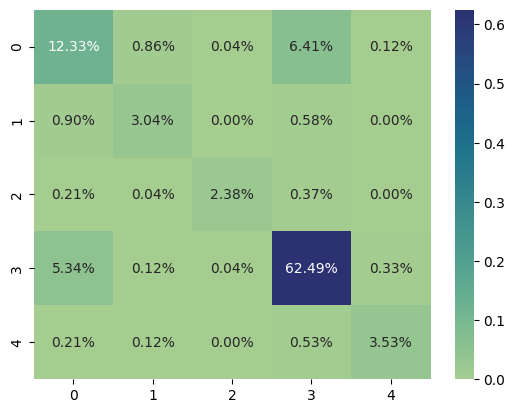

In [11]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, fmt='.2%', cmap='crest')

In [14]:
le.inverse_transform([0]) 

array(['Attempts to collect debt not owed'], dtype=object)

In [15]:
le.inverse_transform([3]) 

array(['Incorrect information on your report'], dtype=object)

Text Classification Using an LSTM

In [16]:
X = [[x for x in regexp_tokenize(sentence.lower(), pattern = r"[a-z]+")] for sentence in reviews['Consumer complaint narrative'].tolist()] 

In [17]:
tokens = sorted(set([x for sentence in X for x in sentence]))

token_index = {word:i + 1 for i, word in enumerate(tokens)}
index_token = {i + 1:word for i, word in enumerate(tokens)}

# We need to reserve the zero token for when we pad our sequences.
vocab_size = len(token_index) + 1

In [18]:
X = [[token_index[word] for word in sentence] for sentence in X]

In [19]:
pd.Series([len(sentence) for sentence in X]).describe()

count    7829.000000
mean       77.850556
std       103.816742
min         1.000000
25%        25.000000
50%        45.000000
75%        88.000000
max      1671.000000
dtype: float64

In [20]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen = 100)

In [21]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4854,
       1491, 4442, 2578, 4901, 4442, 7370, 5308, 1906, 5379, 5405,  271,
       5424, 1473, 8232,  592, 7647, 7897, 6754, 6495, 5022, 1111, 7897,
       5424, 3655, 3834,  412, 3258, 6562, 4734, 7054, 1744,   81, 4167,
       3992, 3117, 7616, 1390, 5410, 5800, 1597, 6137, 4916, 3185, 8300,
       1576, 6137,  391, 1597, 6137, 1856, 5151,  670, 5512, 1958,   81,
        487], dtype=int32)

In [22]:
y = reviews['Issue']

le = LabelEncoder().fit(y)
y = le.transform(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state = 321, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state = 321, stratify = y_train_val)

In [23]:
lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 128, mask_zero = True))
lstm_model.add(tf.keras.layers.LSTM(32))
lstm_model.add(tf.keras.layers.Dense(32))
lstm_model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

lstm_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [24]:
history = lstm_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs=100, callbacks=[callback])

Epoch 1/100
138/138 [==============================] - 62s 411ms/step - loss: 0.7795 - accuracy: 0.7079 - val_loss: 0.6305 - val_accuracy: 0.7486
Epoch 2/100
138/138 [==============================] - 49s 350ms/step - loss: 0.5254 - accuracy: 0.7920 - val_loss: 0.5357 - val_accuracy: 0.7977
Epoch 3/100
138/138 [==============================] - 46s 337ms/step - loss: 0.4171 - accuracy: 0.8376 - val_loss: 0.5197 - val_accuracy: 0.7990
Epoch 4/100
138/138 [==============================] - 45s 323ms/step - loss: 0.3493 - accuracy: 0.8696 - val_loss: 0.5102 - val_accuracy: 0.8202
Epoch 5/100
138/138 [==============================] - 41s 295ms/step - loss: 0.2961 - accuracy: 0.8955 - val_loss: 0.5632 - val_accuracy: 0.8120
Epoch 6/100
138/138 [==============================] - 41s 297ms/step - loss: 0.2579 - accuracy: 0.9107 - val_loss: 0.5470 - val_accuracy: 0.8079
Epoch 7/100
138/138 [==============================] - 40s 288ms/step - loss: 0.2232 - accuracy: 0.9248 - val_loss: 0.6020 -

In [25]:
y_pred = np.argmax(lstm_model.predict(X_test), axis = 1)

confusion_matrix(y_test, y_pred) 

62/62 [==============================] - 2s 20ms/step


array([[ 186,   39,    2,  166,    3],
       [  20,   43,    6,    5,    1],
       [   2,    4,   41,    3,    7],
       [  83,    5,    5, 1246,    7],
       [   3,    1,    3,   18,   59]])

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       396
           1       0.47      0.57      0.51        75
           2       0.72      0.72      0.72        57
           3       0.87      0.93      0.90      1346
           4       0.77      0.70      0.73        84

    accuracy                           0.80      1958
   macro avg       0.69      0.68      0.68      1958
weighted avg       0.80      0.80      0.80      1958



LSTM layer Bidirectional

In [27]:
lstm_model = tf.keras.models.Sequential()

lstm_model.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 128, mask_zero = True))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
lstm_model.add(tf.keras.layers.Dense(32))
lstm_model.add(tf.keras.layers.Dense(5, activation = 'softmax'))

lstm_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [28]:
history = lstm_model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    epochs=100, callbacks=[callback])

Epoch 1/100
138/138 [==============================] - 92s 602ms/step - loss: 0.7204 - accuracy: 0.7340 - val_loss: 0.5917 - val_accuracy: 0.7636
Epoch 2/100
138/138 [==============================] - 78s 564ms/step - loss: 0.4458 - accuracy: 0.8269 - val_loss: 0.5102 - val_accuracy: 0.8120
Epoch 3/100
138/138 [==============================] - 78s 565ms/step - loss: 0.3306 - accuracy: 0.8851 - val_loss: 0.4516 - val_accuracy: 0.8379
Epoch 4/100
138/138 [==============================] - 75s 543ms/step - loss: 0.2424 - accuracy: 0.9157 - val_loss: 0.4915 - val_accuracy: 0.8297
Epoch 5/100
138/138 [==============================] - 73s 531ms/step - loss: 0.1954 - accuracy: 0.9341 - val_loss: 0.5162 - val_accuracy: 0.8243
Epoch 6/100
138/138 [==============================] - 73s 530ms/step - loss: 0.1526 - accuracy: 0.9494 - val_loss: 0.5927 - val_accuracy: 0.8324


In [29]:
y_pred = np.argmax(lstm_model.predict(X_test), axis = 1)

confusion_matrix(y_test, y_pred) 

62/62 [==============================] - 6s 56ms/step


array([[ 215,   24,    4,  152,    1],
       [  24,   45,    1,    5,    0],
       [   1,    5,   40,    9,    2],
       [  87,    4,    2, 1247,    6],
       [   0,    4,    2,   19,   59]])

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59       396
           1       0.55      0.60      0.57        75
           2       0.82      0.70      0.75        57
           3       0.87      0.93      0.90      1346
           4       0.87      0.70      0.78        84

    accuracy                           0.82      1958
   macro avg       0.75      0.69      0.72      1958
weighted avg       0.81      0.82      0.81      1958

